# Goals

1. Predict what feature/attribute or combinations will lead to the highest percentage of score 1? 
2. What algorithms and methods would you use? 
3. What feature or features produce the best result? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('Lead_Verifiy_Response.csv')
headers = df.columns
headers = headers.map(lambda x: x.replace(' ', '_'))
df.columns = headers
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
ORDER                    10000 non-null int64
First_Name               10000 non-null object
Last_Name                10000 non-null object
Mailing_Street           10000 non-null object
Mailing_City             10000 non-null object
Mailing_State            10000 non-null object
Mailing_Zip              10000 non-null int64
Phone                    10000 non-null object
Phone_to_Name            9963 non-null object
Phone_Is_Valid           9999 non-null object
Phone_Line_Type          9963 non-null object
Phone_Is_Prepaid         8601 non-null object
Phone_Is_Commercial      9663 non-null object
Address_to_Name          9693 non-null object
Address_Is_Valid         9989 non-null object
Address_Type             9693 non-null object
Address_Is_Active        9497 non-null object
Address_Is_Commercial    9323 non-null object
Call_Disposition         10000 non-null int64
dtypes: int6

## Data Cleaning, Transformation and Exploration

There are several null values in the data. We could impute these using the most frequent values but as we see from the visualization plots later on, this may not be treating the data correctly. Looking through the data, we find that some null values are missing categories (e.g. if a phone is invalid, the corresponding entry for Phone Line Type is null). In these circumstances, it is better to create a new "Invalid Phone" category in order to distinguish between missing data ('Unknown') and invalid data ("Invalid phone").

In [3]:
df.ix[df.Phone_Is_Valid == False, 'Phone_to_Name'] = 'Invalid phone number'

df.ix[(df.Phone_Is_Valid == False) & (df.Phone_Line_Type.isnull()), 'Phone_Line_Type'] = 'Invalid phone'
df.ix[(df.Phone_Is_Valid == False) & (df.Phone_Is_Prepaid.isnull()), 'Phone_Is_Prepaid'] = 'Invalid phone'
df.ix[(df.Phone_Is_Valid == False) & (df.Phone_Is_Commercial.isnull()), 'Phone_Is_Commercial'] = 'Invalid phone'


df.ix[(df.Phone_Is_Valid == True) & (df.Phone_Line_Type.isnull()), 'Phone_Line_Type'] = 'Unknown'
df.ix[(df.Phone_Is_Valid == True) & (df.Phone_Is_Prepaid.isnull()), 'Phone_Is_Prepaid'] = 'Unknown'
df.ix[(df.Phone_Is_Valid == True) & (df.Phone_Is_Commercial.isnull()), 'Phone_Is_Commercial'] = 'Unknown'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
ORDER                    10000 non-null int64
First_Name               10000 non-null object
Last_Name                10000 non-null object
Mailing_Street           10000 non-null object
Mailing_City             10000 non-null object
Mailing_State            10000 non-null object
Mailing_Zip              10000 non-null int64
Phone                    10000 non-null object
Phone_to_Name            9999 non-null object
Phone_Is_Valid           9999 non-null object
Phone_Line_Type          9999 non-null object
Phone_Is_Prepaid         9999 non-null object
Phone_Is_Commercial      9999 non-null object
Address_to_Name          9693 non-null object
Address_Is_Valid         9989 non-null object
Address_Type             9693 non-null object
Address_Is_Active        9497 non-null object
Address_Is_Commercial    9323 non-null object
Call_Disposition         10000 non-null int64
dtypes: int6

In [4]:
df.ix[df.Address_Is_Valid == False, 'Address_to_Name'] = 'Invalid address'

df.ix[(df.Address_Is_Valid == False) & (df.Address_Type.isnull()), 'Address_Type'] = 'Invalid address'
df.ix[(df.Address_Is_Valid == False) & (df.Address_Is_Commercial.isnull()), 'Address_Is_Commercial'] = 'Invalid address'
df.ix[(df.Address_Is_Valid == False) & (df.Address_Is_Active.isnull()), 'Address_Is_Active'] = 'Invalid address'

df.ix[(df.Address_Is_Valid == True) & (df.Address_to_Name.isnull()), 'Address_to_Name'] = 'No match'
df.ix[(df.Address_Is_Valid == True) & (df.Address_Type.isnull()), 'Address_Type'] = 'Unknown'
df.ix[(df.Address_Is_Valid == True) & (df.Address_Is_Commercial.isnull()), 'Address_Is_Commercial'] = 'Unknown'
df.ix[(df.Address_Is_Valid == True) & (df.Address_Is_Active.isnull()), 'Address_Is_Active'] = 'Unknown'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
ORDER                    10000 non-null int64
First_Name               10000 non-null object
Last_Name                10000 non-null object
Mailing_Street           10000 non-null object
Mailing_City             10000 non-null object
Mailing_State            10000 non-null object
Mailing_Zip              10000 non-null int64
Phone                    10000 non-null object
Phone_to_Name            9999 non-null object
Phone_Is_Valid           9999 non-null object
Phone_Line_Type          9999 non-null object
Phone_Is_Prepaid         9999 non-null object
Phone_Is_Commercial      9999 non-null object
Address_to_Name          9989 non-null object
Address_Is_Valid         9989 non-null object
Address_Type             9989 non-null object
Address_Is_Active        9989 non-null object
Address_Is_Commercial    9989 non-null object
Call_Disposition         10000 non-null int64
dtypes: int6

We can drop the 'Phone_Is_Valid' and 'Address_Is_Valid' columns now since all their data is contained in the subsequent types.

In [5]:
df.drop('Phone_Is_Valid', axis = 1, inplace = True)
df.drop('Address_Is_Valid', axis = 1, inplace = True)

In [6]:
df_noNA = df.dropna(axis=0, how='any')
df_noNA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9989 entries, 0 to 9999
Data columns (total 17 columns):
ORDER                    9989 non-null int64
First_Name               9989 non-null object
Last_Name                9989 non-null object
Mailing_Street           9989 non-null object
Mailing_City             9989 non-null object
Mailing_State            9989 non-null object
Mailing_Zip              9989 non-null int64
Phone                    9989 non-null object
Phone_to_Name            9989 non-null object
Phone_Line_Type          9989 non-null object
Phone_Is_Prepaid         9989 non-null object
Phone_Is_Commercial      9989 non-null object
Address_to_Name          9989 non-null object
Address_Type             9989 non-null object
Address_Is_Active        9989 non-null object
Address_Is_Commercial    9989 non-null object
Call_Disposition         9989 non-null int64
dtypes: int64(3), object(14)
memory usage: 1.4+ MB


Create one-hot-encoded dummy variables for preparing the data before it can be run through any models.

In [7]:
print("Original Features", list(df_noNA.columns), "\n")
data = df_noNA[['Phone_to_Name', 'Phone_Line_Type', 
                'Phone_Is_Prepaid', 'Phone_Is_Commercial', 'Address_to_Name', 'Address_Type', 'Address_Is_Active', 
                'Address_Is_Commercial']]
data_dummies = pd.get_dummies(data)
print("Features after get_dummies: \n", list(data_dummies.columns))

Original Features ['ORDER', 'First_Name', 'Last_Name', 'Mailing_Street', 'Mailing_City', 'Mailing_State', 'Mailing_Zip', 'Phone', 'Phone_to_Name', 'Phone_Line_Type', 'Phone_Is_Prepaid', 'Phone_Is_Commercial', 'Address_to_Name', 'Address_Type', 'Address_Is_Active', 'Address_Is_Commercial', 'Call_Disposition'] 

Features after get_dummies: 
 ['Phone_to_Name_Invalid phone number', 'Phone_to_Name_Match', 'Phone_to_Name_No match', 'Phone_to_Name_No name found', 'Phone_Line_Type_Fixed VOIP', 'Phone_Line_Type_Invalid phone', 'Phone_Line_Type_Landline', 'Phone_Line_Type_Mobile', 'Phone_Line_Type_Non-fixed VOIP', 'Phone_Line_Type_Tollfree', 'Phone_Is_Prepaid_False', 'Phone_Is_Prepaid_True', 'Phone_Is_Prepaid_Invalid phone', 'Phone_Is_Prepaid_Unknown', 'Phone_Is_Commercial_False', 'Phone_Is_Commercial_True', 'Phone_Is_Commercial_Invalid phone', 'Phone_Is_Commercial_Unknown', 'Address_to_Name_Invalid address', 'Address_to_Name_Match', 'Address_to_Name_No match', 'Address_to_Name_No name found', '

In [8]:
to_append = df_noNA[['ORDER', 'First_Name', 'Last_Name', 'Mailing_Street', 
                     'Mailing_City', 'Mailing_State', 'Mailing_Zip', 'Phone', 'Call_Disposition']]
data = to_append.join(data_dummies.ix[:,:])

#Reorder columns
data['Result'] = df_noNA['Call_Disposition']
del data['Call_Disposition']

In [9]:
data['Call_Disposition'] = data['Result']
del data['Result']

In [10]:
data.head()

,ORDER,First_Name,Last_Name,Mailing_Street,Mailing_City,Mailing_State,Mailing_Zip,Phone,Phone_to_Name_Invalid phone number,Phone_to_Name_Match,...,Address_Type_Unknown address type,Address_Is_Active_False,Address_Is_Active_True,Address_Is_Active_Invalid address,Address_Is_Active_Unknown,Address_Is_Commercial_False,Address_Is_Commercial_True,Address_Is_Commercial_Invalid address,Address_Is_Commercial_Unknown,Call_Disposition
0,1,Donald,Mathews,789 Cambridge Place,Hanover,MD,21076,860-452-9151,0,0,...,0,0,1,0,0,0,1,0,0,5
1,2,Sharon,Ogden,3929 Timber Ridge Road,Sacramento,CA,95814,213-624-4444,0,0,...,0,0,1,0,0,0,1,0,0,5
2,3,Timothy,Villa,4493 Freedom Lane,Stockton,CA,95204,309-578-4670,0,1,...,1,0,0,0,1,0,1,0,0,1
3,4,Stephen,Jackson,1739 Five Points,Salisbury,MD,21875,563-574-3653,0,0,...,0,0,1,0,0,1,0,0,0,6
4,5,Emilie,Sierra,2969 Bell Street,New York,NY,10022,408-236-9031,0,0,...,0,0,1,0,0,0,1,0,0,6


In [11]:
pd.options.display.max_columns = 999
data.describe(include = 'all')

,ORDER,First_Name,Last_Name,Mailing_Street,Mailing_City,Mailing_State,Mailing_Zip,Phone,Phone_to_Name_Invalid phone number,Phone_to_Name_Match,Phone_to_Name_No match,Phone_to_Name_No name found,Phone_Line_Type_Fixed VOIP,Phone_Line_Type_Invalid phone,Phone_Line_Type_Landline,Phone_Line_Type_Mobile,Phone_Line_Type_Non-fixed VOIP,Phone_Line_Type_Tollfree,Phone_Is_Prepaid_False,Phone_Is_Prepaid_True,Phone_Is_Prepaid_Invalid phone,Phone_Is_Prepaid_Unknown,Phone_Is_Commercial_False,Phone_Is_Commercial_True,Phone_Is_Commercial_Invalid phone,Phone_Is_Commercial_Unknown,Address_to_Name_Invalid address,Address_to_Name_Match,Address_to_Name_No match,Address_to_Name_No name found,Address_Type_Commercial mail drop,Address_Type_Invalid address,Address_Type_Multi unit,Address_Type_PO box,Address_Type_PO box throwback,Address_Type_Single unit,Address_Type_Unknown,Address_Type_Unknown address type,Address_Is_Active_False,Address_Is_Active_True,Address_Is_Active_Invalid address,Address_Is_Active_Unknown,Address_Is_Commercial_False,Address_Is_Commercial_True,Address_Is_Commercial_Invalid address,Address_Is_Commercial_Unknown,Call_Disposition
count,9989.000000,9989,9989,9989,9989,9989,9989.000000,9989,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000
unique,NaN,1831,4557,9984,2780,51,NaN,9989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,James,Smith,2533 Boundary Street,New York,CA,NaN,413-437-9481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,195,138,2,181,1078,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4999.749524,NaN,NaN,NaN,NaN,NaN,50472.669136,NaN,0.003604,0.367905,0.598458,0.030033,0.302032,0.003604,0.423366,0.049755,0.217139,0.004105,0.859045,0.001101,0.003604,0.136250,0.152568,0.813795,0.003604,0.030033,0.013215,0.366603,0.583342,0.036841,0.007008,0.013215,0.378116,0.048854,0.009811,0.503454,0.016418,0.023125,0.015017,0.935729,0.013215,0.036040,0.152267,0.781059,0.013215,0.053459,3.333567
std,2886.471138,NaN,NaN,NaN,NaN,NaN,29248.805488,NaN,0.059928,0.482259,0.490235,0.170687,0.459162,0.059928,0.494117,0.217449,0.412319,0.063938,0.347993,0.033168,0.059928,0.343071,0.359588,0.389291,0.059928,0.170687,0.114198,0.481901,0.493030,0.188380,0.083422,0.114198,0.484941,0.215573,0.098567,0.500013,0.127083,0.150309,0.121624,0.245247,0.114198,0.186398,0.359298,0.413549,0.114198,0.224958,2.022762
min,1.000000,NaN,NaN,NaN,NaN,NaN,1001.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2501.000000,NaN,NaN,NaN,NaN,NaN,27409.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
50%,4999.000000,NaN,NaN,NaN,NaN,NaN,48174.000000,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,0.00

## Visualizing the Data

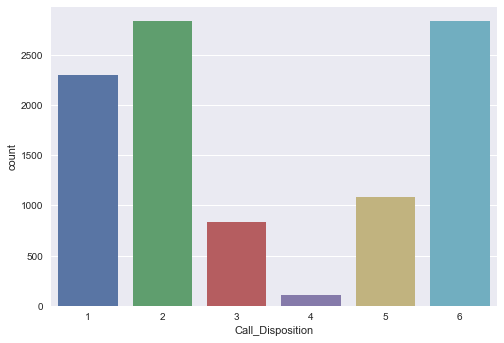

In [12]:
data_to_plot = df_noNA[['Phone_to_Name', 'Phone_Line_Type', 
                'Phone_Is_Prepaid', 'Phone_Is_Commercial', 'Address_to_Name', 
                   'Address_Type', 'Address_Is_Active', 
                'Address_Is_Commercial', 'Call_Disposition']]
sns.set()
sns.countplot(x="Call_Disposition", data=data_to_plot)

From the plot above, we can see there is a class imbalance for a score of 4. We could potentially combine scores 3, 4 and 5 to reduce the problem from a 6-class classification to a 4-class classification.

One possible cause for such an imbalance is a bias in the reporting i.e. people are likely to report a lead as either high value or low value, but not medium value.

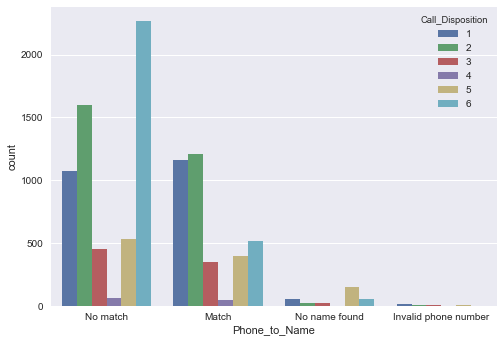

In [13]:
sns.countplot(x="Phone_to_Name", hue="Call_Disposition", data=data_to_plot)

The most common category is 'No match'. The data here suggests this may not be a useful feature for a score of 1 (roughly equal counts for score 1 in 'No match' & 'Match', but could be useful for classifying scores of 6.

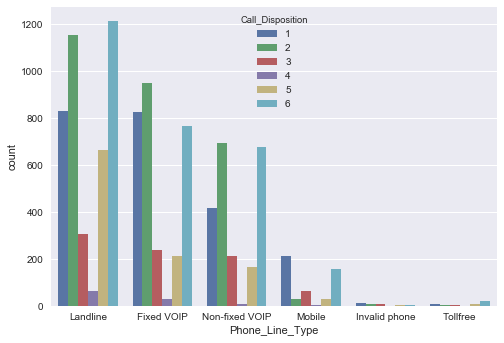

In [14]:
sns.countplot(x="Phone_Line_Type", hue="Call_Disposition", data=data_to_plot)

This feature is unlikely to have a strong correlation with Call Disposition as the distribution is repeated for each category.

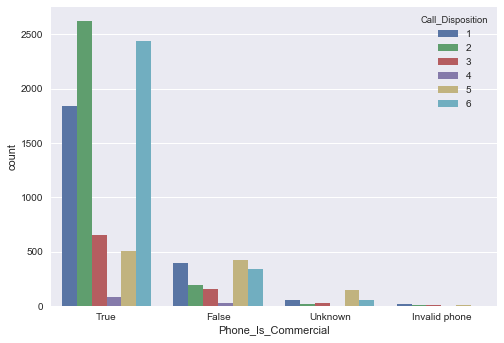

In [15]:
sns.countplot(x="Phone_Is_Commercial", hue="Call_Disposition", data=data_to_plot)

Focusing on call dispositions 1 & 6 we see that for phones that are commerical (Phone_Is_Commerical=True) Call Dispositions 6 occurs more than 1. However for phones that are not commerical, these two categories occur approximately equally . This suggests that this may be a useful feature.

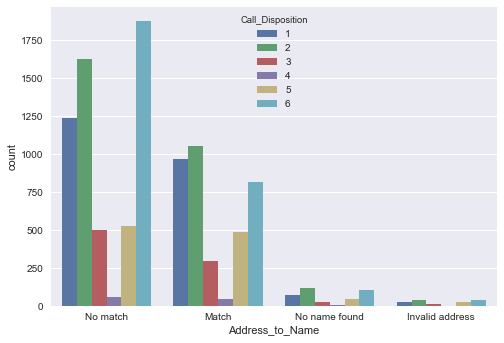

In [16]:
sns.countplot(x="Address_to_Name", hue="Call_Disposition", data=data_to_plot)

Similar to the Phone_Is_Commerical feature, match & no match for the Address_to_Name feature seems to distinuish well between Call Dispositions 1 & 6

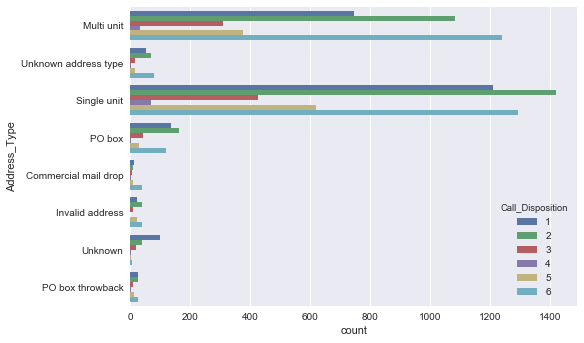

In [17]:
sns.countplot(y="Address_Type", hue="Call_Disposition", data=data_to_plot)

The majority of the observed Address_Types are Multi or Single unit. Between these, there is an approximately similar distribution of Call Dispositions, suggesting this is not likely to be an important feature

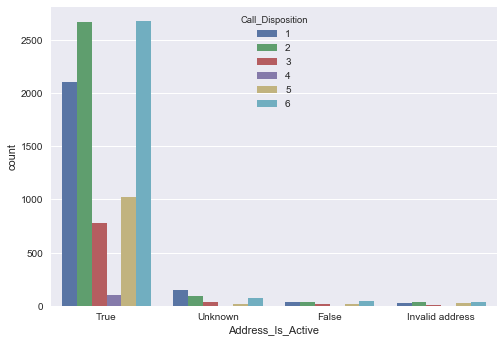

In [18]:
sns.countplot(x="Address_Is_Active", hue="Call_Disposition", data=data_to_plot)

Because the majority of Addresses are active (Address_Is_Active=True), this attribute is not likely to be discriminating.

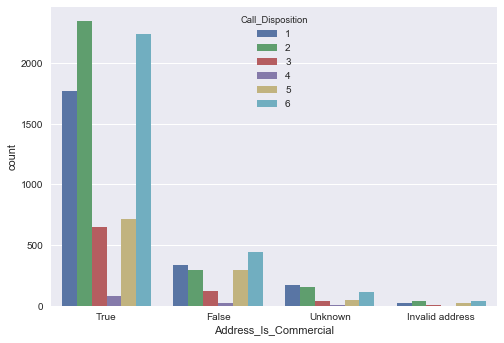

In [19]:
sns.countplot(x="Address_Is_Commercial", hue="Call_Disposition", data=data_to_plot)

While unlikely to significantly distinguish between Call Dispositions 1 & 6, Address_Is_Commerical may provide a strong signal for distinguishing Call Dispositions 1 & 2

In [20]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    #plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    

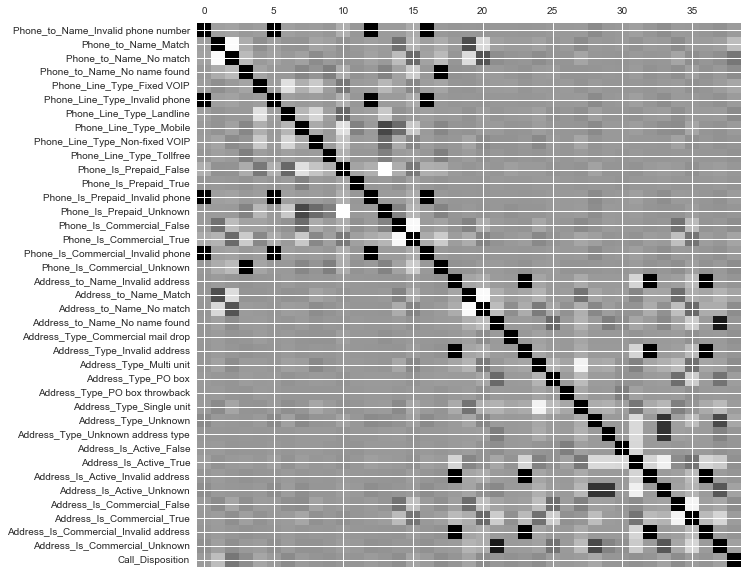

In [21]:
"""Plot the correlation matrix to examine correlations between each pair of features and the target Result.

"""
to_corr = data[data.columns[8:]]

plot_corr(to_corr)


Plotting the correlation matrix on the one-hot-encoded features shows:
  1. No single feature is strongly correlated with Call_Disposition (the complete list of correlations to Call_Disposition is below)
  2. There is significant correlation between certain features. For example Phone_Is_Commerical_Invalid_phone is highly correlated with Phone_to_Name_Invalid_phone (which is to be expected)

In [22]:
corr_data = to_corr.corr()
print(corr_data['Call_Disposition'].sort_values(ascending=True))

Phone_to_Name_Match                     -0.245181
Address_Type_Unknown                    -0.104656
Phone_Line_Type_Fixed VOIP              -0.091884
Phone_Is_Commercial_True                -0.078648
Address_to_Name_Match                   -0.076882
Address_Is_Active_Unknown               -0.070126
Address_Is_Commercial_Unknown           -0.055034
Address_Type_PO box                     -0.039442
Address_Type_Single unit                -0.033014
Address_Is_Commercial_True              -0.030938
Phone_Is_Commercial_Invalid phone       -0.028089
Phone_Is_Prepaid_Invalid phone          -0.028089
Phone_to_Name_Invalid phone number      -0.028089
Phone_Line_Type_Invalid phone           -0.028089
Phone_Line_Type_Mobile                  -0.018388
Address_Type_PO box throwback           -0.006372
Phone_Is_Prepaid_False                  -0.002751
Address_to_Name_No name found            0.005057
Address_Type_Unknown address type        0.005251
Phone_Is_Prepaid_Unknown                 0.006206


It is clear that Phone_to_Name is the feature most highly correlated with Call_Disposition. Note that No_Match is positively correlated, meaning that when No Match is 1 (True) the Call_Disposition is more likely to be high (i.e. a less positive lead). This explains why Phone_to_Name_Match is *negatively* correlated with Call_Disposition.

In [23]:
# Setting up the training (70%) and test (30%) sets
np.random.seed(42)
msk1 = np.random.rand(len(data)) < 0.7
train = data[msk1]
test = data[~msk1]

In [24]:
features = train.columns[8:-1]

## Model Selection

In the following cells several classifier algorithms are tested, with the cross-validation accuracy outputted for each.

In [25]:
# Consider model options and evaluate metrics using k-folds cross-validation
num_folds = 10
num_instances = len(train[features])
seed = 42
scoring = 'accuracy'
models = []

models.append(('LR', LogisticRegression(solver='lbfgs', multi_class = 'multinomial')))  # Logisitic Regression
models.append(('NB', BernoulliNB()))                                                    # Naive Bayes Bernoulli classifier
models.append(('SVM', SVC(kernel='rbf')))                                               # Support Vector Classifier
models.append(('KNN', KNeighborsClassifier()))                                          # K-Nearest neighbours
models.append(('NN', MLPClassifier()))                                                  # Neural Network (single hidden layer)
models.append(('DNN', MLPClassifier(hidden_layer_sizes = (38,38,6))))                   # Deep Learning Neural Network
models.append(('CART', DecisionTreeClassifier()))                                       # Decision Tree Classifier
models.append(('RF', RandomForestClassifier(n_estimators=100)))                         # Random Forest Classifier
models.append(('ERF', ExtraTreesClassifier(n_estimators=100)))                          # Extra Random Forest Classifier
models.append(('AB', AdaBoostClassifier(n_estimators=100)))                             # Ada Boost Classifier
models.append(('GB', GradientBoostingClassifier(n_estimators=100)))                     # Gradient Boosting Classifier


# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train[features], train['Call_Disposition'], cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.377939 (0.042892)
NB: 0.369489 (0.023141)
SVM: 0.385675 (0.036127)
KNN: 0.310944 (0.054199)
NN: 0.381327 (0.051265)
DNN: 0.382026 (0.045232)
CART: 0.364717 (0.049240)
RF: 0.364857 (0.048750)
ERF: 0.363310 (0.049151)
AB: 0.364292 (0.042477)
GB: 0.373865 (0.049345)


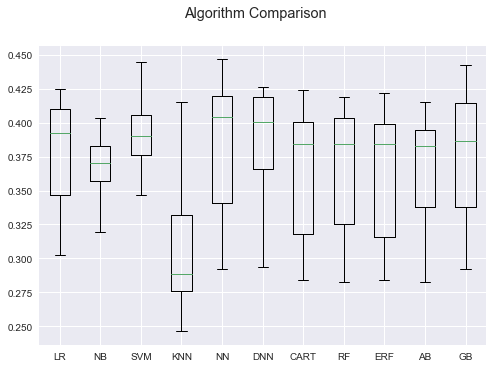

In [26]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Focusing on the Support Vector Machine and Deep Neural Network models since they have the higest (pre-tuned) accuracy.
Note: Removing gradient boost because, although it has a high maximum accuracy, it also has a high spread in accuracy compared to the other two models

In [27]:
# Compare with NN
parameters = {'alpha':[0.0001, 0.00001, 0.000001], 'hidden_layer_sizes':[(38, 6), (50, 50, 25), (38, 38, 6)]}
NN = MLPClassifier(solver = 'lbfgs', max_iter = 500)

clf = GridSearchCV(NN, parameters)
clf.fit(train[features], train['Call_Disposition'])
clf.get_params(deep=True)
print('Best in-sample accuracy: {}'.format(clf.score(train[features], train['Call_Disposition'])))
print('achieved using: {}'.format(clf.best_params_))
print('The out-of-sample accuracy for these parameters: {}'.format(clf.best_score_))

#0.44449134656
#{'alpha': 1e-06, 'hidden_layer_sizes': (38, 38, 6)}

Best in-sample accuracy: 0.43801885465034474
achieved using: {'alpha': 1e-05, 'hidden_layer_sizes': (38, 6)}
The out-of-sample accuracy for these parameters: 0.3903194034050936


Tuning the deep learning model's architecture (both number of layers and layer width), and the model regularization parameters, results in the model with the highest accuracy.

In [28]:
parameters = {'C':[0.1, 1, 10], 'gamma':[0.01,0.1,1,10]}
SVM = SVC()
clf = GridSearchCV(SVM, parameters)
clf.fit(train[features], train['Call_Disposition'])
clf.get_params(deep=True)
print('Best in-sample accuracy: {}'.format(clf.score(train[features], train['Call_Disposition'])))
print('achieved using: {}'.format(clf.best_params_))
print('The out-of-sample accuracy for these parameters: {}'.format(clf.best_score_))

Best in-sample accuracy: 0.4053749824117068
achieved using: {'C': 10, 'gamma': 0.01}
The out-of-sample accuracy for these parameters: 0.40551568875756294


Tuning the support vector machine's regularization and kernel coefficient parameters, results in the model with the highest accuracy.

The (tuned) deep learning model out performs the support vector machine's accuracy by (approx) 10%, and will be focused on in the following.

[ 0.69767442  0.59930691  0.50403071  0.47008081  0.45612554]
[ 0.30407448  0.33882302  0.36513025  0.37511957  0.38863113]


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

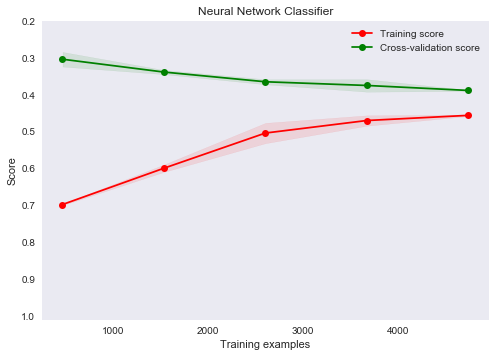

In [29]:
#Plot learning curves using sklearn's default learning curve plotting function

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    print(train_scores_mean)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print(test_scores_mean)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Neural Network Classifier"

plot_learning_curve(MLPClassifier(solver = 'lbfgs', max_iter = 500, alpha = 1e-6, hidden_layer_sizes = (38, 38, 6)), 
                    title, train[features], train['Call_Disposition'], ylim=(1.01, 0.2))  

# Learning curve shows we are not in high bias or high variance regimes and the model is making reasonable predictions

To ensure that the model isn't significantly overfitting, the learning curves are plotted. 

The gap between the cross-validation and training scores indicates that there some amount of overfitting occuring, indicating that the model could benefit from additional data. If the full data set were limited to the current 10,000 examples, introducing additional regularization could also reduce this overfitting.

## Model Training

Having selected the best classifier, and tuned the hyper parameters, we now train and evaluate the optimal model.

In [30]:

# Initialize Neural Network model
NN = MLPClassifier(solver = 'lbfgs', max_iter = 500, alpha = 1e-6, hidden_layer_sizes = (38, 38, 6))

# Train the model
NN.fit(X = train[features] ,
              y = train['Call_Disposition'])
preds = NN.predict(X= train[features])

predstest = NN.predict(X=test[features])
ytest = test['Call_Disposition']


In [31]:
# Confusion matrix for NN classifier
print(confusion_matrix(ytest, predstest))

[[112 309   0   0  42 220]
 [ 55 402   0   0  27 329]
 [ 28  69   0   0  20 115]
 [  3   9   0   0   6  22]
 [ 32  53   0   0 113 126]
 [ 39 175   0   0  39 537]]


## Model Evaluation

In [32]:
print(classification_report(ytest, predstest))

             precision    recall  f1-score   support

          1       0.42      0.16      0.24       683
          2       0.40      0.49      0.44       813
          3       0.00      0.00      0.00       232
          4       0.00      0.00      0.00        40
          5       0.46      0.35      0.40       324
          6       0.40      0.68      0.50       790

avg / total       0.37      0.40      0.36      2882



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


It is clear that the lack of data for Call Dispositions 3 & 4 has adversely effected the model's ability to predict these classes. It is also worth nothing that the combined accuracy for grouping classes 1 & 2 would likely be somewhat higher. This leads to the possibility of producing a better model, if it were sufficent to predict three classes of Call Disposition (High, Medium and Low). Obviously any such decision would require a deeper understanding of the use-cases & business needs.

Note: Considering only the accuracy of the 4 classes that the model was able to predict, the overall precision is 0.41, and the recall is 0.43.

## Summary

Having tested multiple models, a deep learning neural network (with 3 hidden layers) provides the highest overall prediciton accuracy. 

Because neural networks encode the input to output mapping in multiple layers, it is impossible to extract an intuitive understanding of which combinations of features have been selected by the model. However, the trained model provides a definition of that mapping i.e. given any input, the model provides the optimum predicted class.

One point of note: because the neural network has multiple hidden layers, all possible interaction terms (up to 3rd order) have been considered by the model. The result can be viewed as a compact way of encoding the most efficient combination of all cubic combinations of the original features.

This leads to the obvious follow-up: why not include additional layers? As shown above, the exisiting model is already beginning to suffer from over-fitting, and this problem will increase significantly as the number of layers is increased. With the limited volume of data provided, a deeper network is not likely to improve the out-of-sample accuracy.